# Profile Sensitivity Tests

## Setting up environment

In [1]:
import sys
import pandas as pd
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")

# Set up dask cluster to help with computation
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36673")
client

DEBUG    23:33:01 	 ApRESDefs.py @function _setup_logging line 490 - Stream logging level set to DEBUG
DEBUG    23:33:01 	 ApRESDefs.py @function _setup_logging line 491 - Add console handler to logger
DEBUG    23:33:01 	 ApRESDefs.py @function _setup_logging line 504 - File logging level set to DEBUG


Connection method: Direct,
Dashboard: /user/glugeorge/proxy/8787/status,
Comm: tcp://127.0.0.1:36673,Workers: 0
Dashboard: /user/glugeorge/proxy/8787/status,Total threads: 0
Started: 3 hours ago,Total memory: 0 B


## Selecting 'Good' and 'Bad' data

In [2]:
good_burst = ds_101.isel(time=1000).compute()
bad_burst = ds_101.isel(time=7062).compute()


## Sensitivity Tests

For each of these sensitivity tests, we will be plotting the profile for a single chirp, for good vs bad, followed by a stacked burst. 

### Attenuator

Text(0, 0.5, 'Amplitude [dB]')

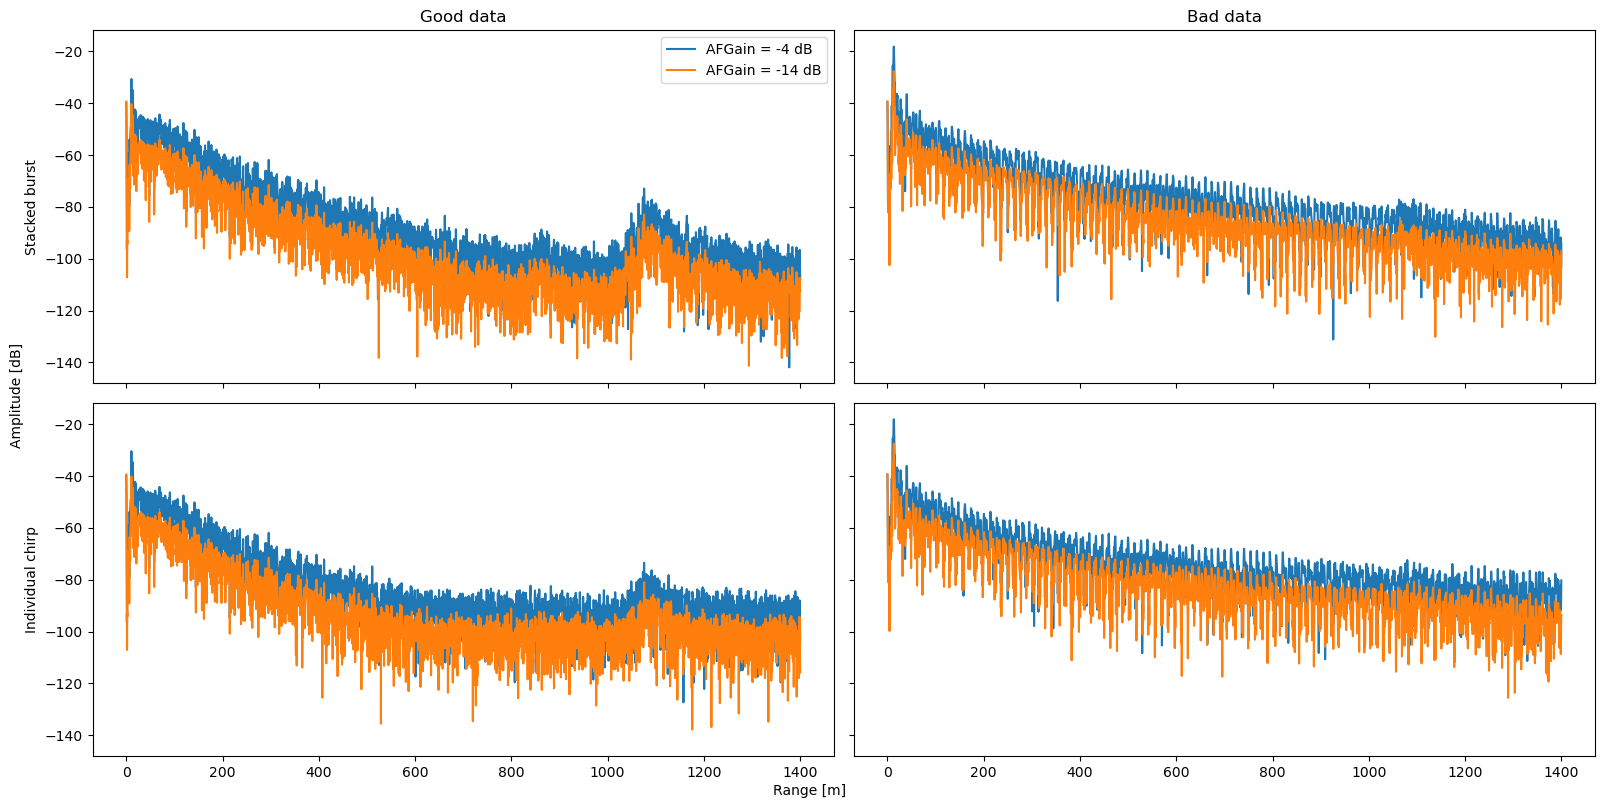

In [43]:
# Chirp
good_chirp = good_burst.isel(chirp_num = 0)
bad_chirp = bad_burst.isel(chirp_num = 0)
fig, axs = plt.subplots(nrows = 2, ncols = 2,sharex=True, sharey=True,figsize=(16,8))
axs[0,0].plot(good_burst.profile_range,xa.dB(good_burst.profile_stacked))
axs[0,0].set_title('Good data')
axs[0,0].set_ylabel('Stacked burst')
axs[0,1].plot(bad_burst.profile_range,xa.dB(bad_burst.profile_stacked))
axs[0,1].set_title('Bad data')
axs[1,0].set_ylabel('Individual chirp')

axs[1,0].plot(good_chirp.profile_range,xa.dB(good_chirp.profile))
axs[1,1].plot(bad_chirp.profile_range,xa.dB(bad_chirp.profile))

axs[0,0].legend(['AFGain = -4 dB','AFGain = -14 dB'])
fig.tight_layout()
fig.text(0.5, 0, 'Range [m]', ha='center')
fig.text(0, 0.5, 'Amplitude [dB]', va='center', rotation='vertical')


From above, it looks like the higher gain lowers the overall signal, but doesn't really seem to change the quality of the burst, notably seen with the "bad" data. Between the stacked burst and the chirp, the stacking lowers the overall noise floor for the "good" data, but doesn't seem to improve the "bad" data.

### Pad factor
The default pad factor that has been used is 2. Let us examine what happens when that is changed. For simplicity, we will use the lower gain setting for the remaining sensitivity tests as the overall goal is to reduce the noise floor.

In [5]:
# Reselect data with desired attenuator setting
good_burst = ds_101.isel(attenuator_setting_pair = 1,time=1000).compute()
bad_burst = ds_101.isel(attenuator_setting_pair = 1,time=7062).compute()
good_chirp = good_burst.isel(chirp_num = 0)
bad_chirp = bad_burst.isel(chirp_num = 0)

In [6]:
# Define functions with which we can calculate new profiles with
def custom_profile(chirp,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K
    
    chirp = chirp[math.ceil(T0/dt):math.floor(T1/dt)+1]
    win_chirp = (chirp*np.blackman(len(chirp)))
    Nt = len(win_chirp)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros(Nfft)
    padchirp[0:math.floor(Nt/2)] = win_chirp.data[math.floor(Nt/2):-1]
    padchirp[-math.floor(Nt/2):] = win_chirp.data[0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp)/Nfft * math.sqrt(2*pad)
    profile = p[0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(len(profile))])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:n]

    return Range, Profile

def custom_profile_stacked(burst,pad=2,F0=2e8,F1=4e8):
    Range,Profile = custom_profile(burst.chirp.isel(chirp_num=0),pad,F0,F1)
    for num in burst.chirp_num.data:
        r_temp,p_temp = custom_profile(burst.chirp.isel(chirp_num=num),pad,F0,F1)
        Profile += p_temp
    Profile = Profile/len(burst.chirp_num.data)
    return Range, Profile

Text(0, 0.5, 'Amplitude [dB]')

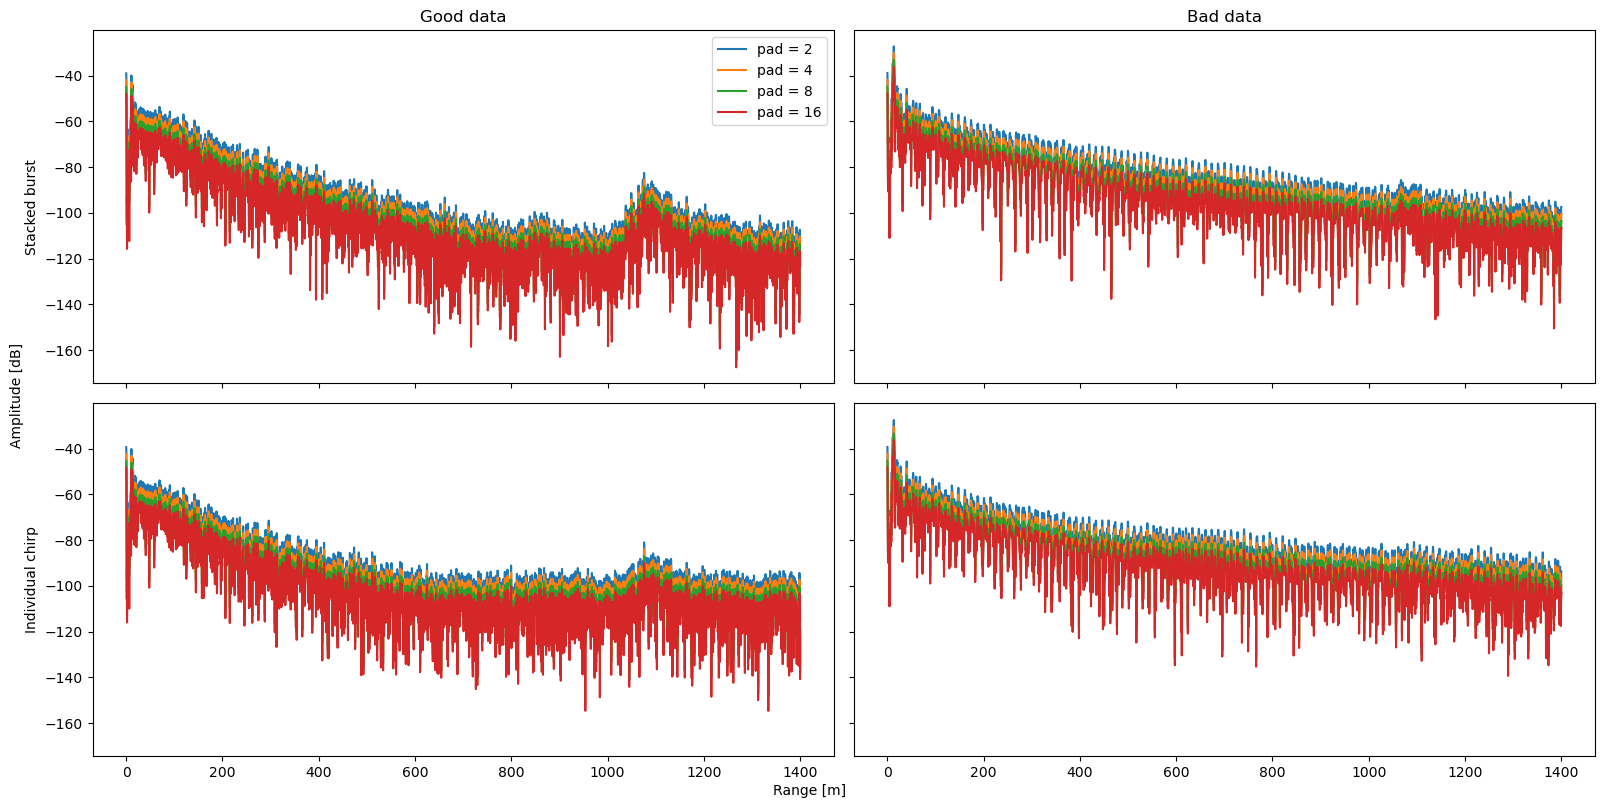

In [51]:
fig, axs = plt.subplots(nrows = 2, ncols = 2,sharex=True, sharey=True,figsize=(16,8))
for pad in [2,4,8,16]:
    good_range_stacked, good_profile_stacked = custom_profile_stacked(good_burst,pad)
    axs[0,0].plot(good_range_stacked,xa.dB(good_profile_stacked),label = f'pad = {pad}')
    
    bad_range_stacked, bad_profile_stacked = custom_profile_stacked(bad_burst,pad)
    axs[0,1].plot(bad_range_stacked,xa.dB(bad_profile_stacked))
    
    good_range, good_profile = custom_profile(good_chirp.chirp,pad)
    axs[1,0].plot(good_range,xa.dB(good_profile))
    
    bad_range, bad_profile = custom_profile(bad_chirp.chirp,pad)
    axs[1,1].plot(bad_range,xa.dB(bad_profile))
                  
axs[0,0].set_title('Good data')
axs[0,0].set_ylabel('Stacked burst')
axs[0,1].set_title('Bad data')
axs[1,0].set_ylabel('Individual chirp')
axs[0,0].legend()
fig.tight_layout()
fig.text(0.5, 0, 'Range [m]', ha='center')
fig.text(0, 0.5, 'Amplitude [dB]', va='center', rotation='vertical')

Padding doesn't really change much, slightly shifts the profile down but that's it. The overall data stays exactly the same. Consequently, we'll probably stick with the regularly assumed p = 2.

### Bandwidth
We noticed in some of our earlier analysis that in the bad data, the chirps were clipped or altered mostly within the first half of the each chirp, at lower frequencies. We will examine the impact of processing a shorter portion of the window to see if it can make the data cleaner

6658
4994
3329
1665


Text(0, 0.5, 'Amplitude [dB]')

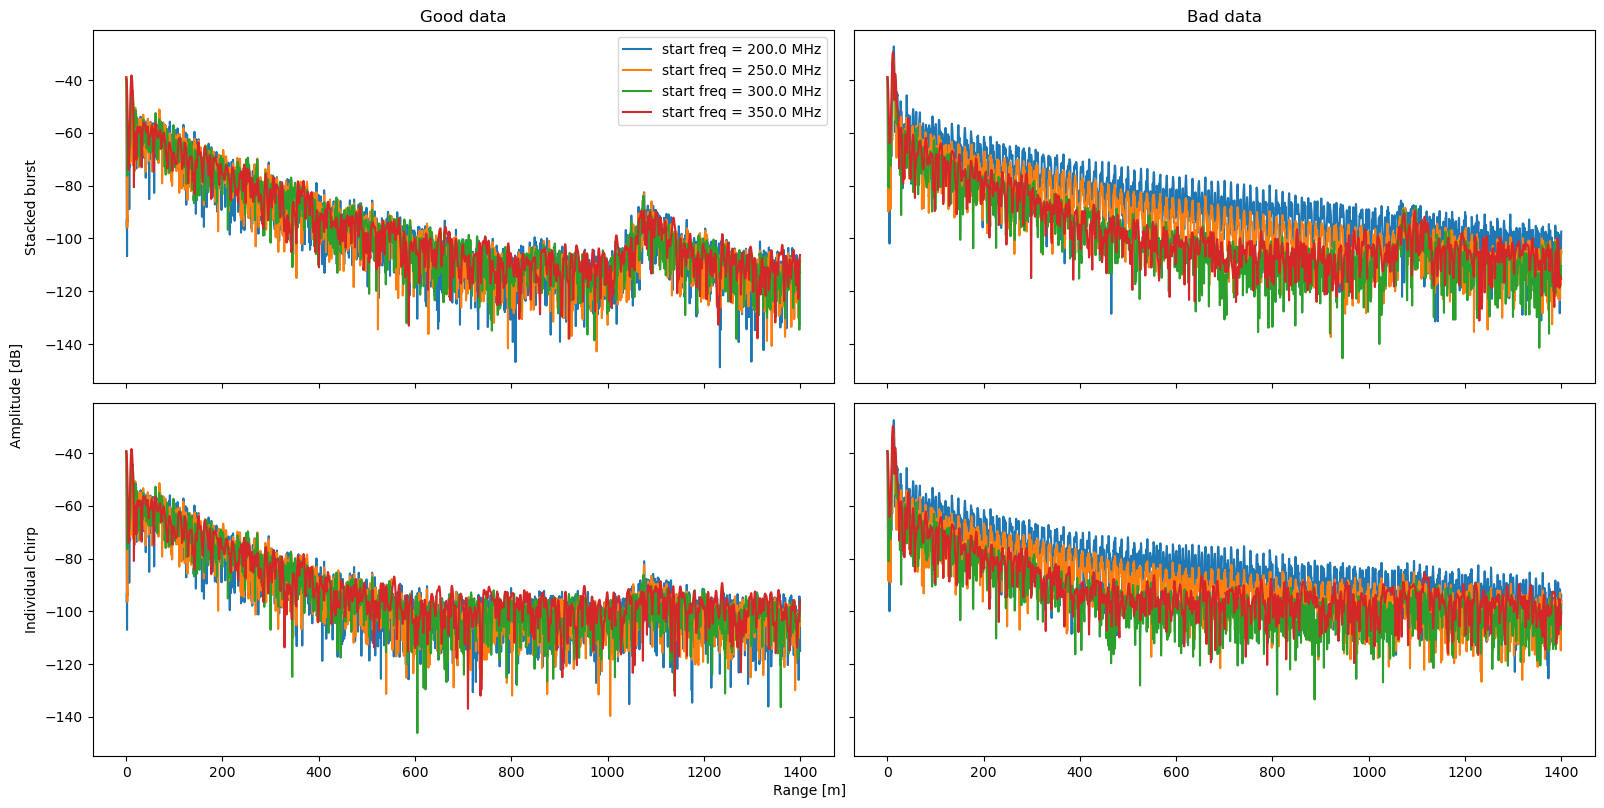

In [10]:
fig, axs = plt.subplots(nrows = 2, ncols = 2,sharex=True, sharey=True,figsize=(16,8))
for F0 in [2e8,2.5e8,3e8,3.5e8]:
    good_range_stacked, good_profile_stacked = custom_profile_stacked(good_burst,2,F0)
    axs[0,0].plot(good_range_stacked,xa.dB(good_profile_stacked),label = f'start freq = {F0/1e6} MHz')
    print(len(good_range_stacked))
    bad_range_stacked, bad_profile_stacked = custom_profile_stacked(bad_burst,2,F0)
    axs[0,1].plot(bad_range_stacked,xa.dB(bad_profile_stacked))
    
    good_range, good_profile = custom_profile(good_chirp.chirp,2,F0)
    axs[1,0].plot(good_range,xa.dB(good_profile))
    
    bad_range, bad_profile = custom_profile(bad_chirp.chirp,2,F0)
    axs[1,1].plot(bad_range,xa.dB(bad_profile))
                  
axs[0,0].set_title('Good data')
axs[0,0].set_ylabel('Stacked burst')
axs[0,1].set_title('Bad data')
axs[1,0].set_ylabel('Individual chirp')
axs[0,0].legend()
fig.tight_layout()
fig.text(0.5, 0, 'Range [m]', ha='center')
fig.text(0, 0.5, 'Amplitude [dB]', va='center', rotation='vertical')

Here, we notice some significant difference. In the "good" data, the larger trends are still folllowed, though the range bins are now different so the finer resolution doesn't match fully. We still see a clear bed reflector. In the bad data, the noise is reduced heavily, and what appears to be an artifact in the signal has vanished mostly. The bed is also a lot more clear in the stacked profile.

In [4]:
ds_101.isel(attenuator_setting_pair=1)

<xarray.Dataset>
Dimensions:          (time: 11723, chirp_time: 40001, chirp_num: 20,
                      profile_range: 6658)
Coordinates:
    AFGain           int64 dask.array<chunksize=(), meta=np.ndarray>
    attenuator       float64 dask.array<chunksize=(), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num) float64 dask.array<chunksize=(20, 40001, 20), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num) complex128 dask.array<chunksize=(20, 6658, 20), meta=np.ndarray>
    profile_stacked  (time, profile_range) complex128 dask.array<chunksize=(20, 6658), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>